In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

#this are the directopriess containing the datasets
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

.DEFINE A FUNCTION THAT read / decode the images and convert them into floating point tensors.

In [ ]:

#defining our image generator functions, here we only need to use rescal
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

The flow from directory method expects the directory you pass to it to have subdirectories.

It will then classify the differents subdirectories as differents classes.

By using **class_mode='binary'** we are specifying that there would be two labels or claases of data here cat and dog

For the test dataset, because it conrains no subdirectories, the flow method will fail. It took ;e reading the doc to understand that in such case, we need to specify **classes=['.']**

For more on [flow_from_directory](https://keras.io/api/preprocessing/image/#flow_from_directory) and [here](https://stackoverflow.com/questions/59633759/how-to-call-the-keras-flow-from-directory-method-on-test-dataset)

In [ ]:

train_data_gen = train_image_generator.flow_from_directory(
        directory = train_dir,
        target_size=((IMG_HEIGHT, IMG_WIDTH)),
        batch_size= batch_size,
        class_mode='binary',

        shuffle=True,
)
val_data_gen = validation_image_generator.flow_from_directory(
        directory = validation_dir,
        #'__MACOSX/cats_and_dogs/validation',
        target_size=((IMG_HEIGHT, IMG_WIDTH)),
        batch_size= batch_size,
        class_mode='binary',

        shuffle=True,
)

test_data_gen = test_image_generator.flow_from_directory(
       directory = test_dir,

        target_size=((IMG_HEIGHT, IMG_WIDTH)),
        batch_size=1,
        class_mode = 'binary',
        classes=[''],

        shuffle=False,

)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


4. Plotting function

[1. 0. 0. 0. 1.]


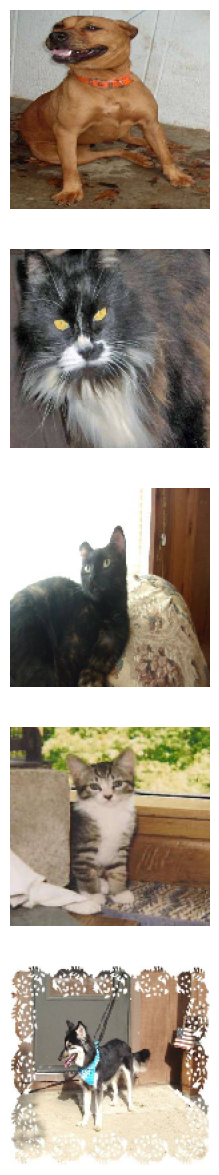

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

#choose five random images from train_data_gen
sample_training_images, _ = next(train_data_gen)
print(_[:5])
plotImages(sample_training_images[:5])


Since there are a small number of training examples, there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

We will add 4-6 random transformations as arguments to ImageDataGenerator and ;make sure to rescale the same as before.

In [ ]:
# 5
train_image_generator = ImageDataGenerator(
    rescale= 1./255,
    #Random transformations
    rotation_range=20, #1
    width_shift_range=0.2, #2
    height_shift_range=0.2, #3
    horizontal_flip=True, #4
    vertical_flip = True, #5,
    fill_mode='nearest',
    shear_range=0.2, #6
    zoom_range=0.2 #7

)


Found 2000 images belonging to 2 classes.


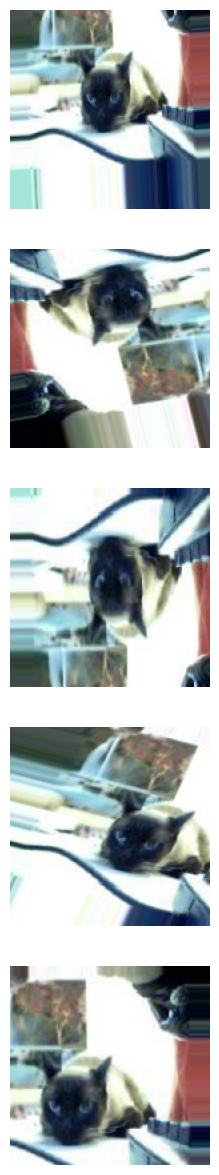

In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

# Remember that train_data_gen returns float32 tensors of shape (batch_size, image_size[0], image_size[1], num_channels)


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
#the number passed to range will determine how many transformations of the image is returned

plotImages(augmented_images)



##.7
it is now time to create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

Then we will compile the model passing the arguments to set the optimizer and loss. Also pass in metrics=['accuracy'] to view training and validation accuracy for each training epoch.

Model Architecture
The model will contain the following Layers:

* Four Convolutional Layers followed by MaxPooling Layers.

* The Flatten layer to flatten the output of the convolutional layer.



* Then we will have three fully connected layers followed by the output of the flattened layer.
* The final layer is the output layer to classify the results into two classes.

In [ ]:
#model1.1

model1 = Sequential([
  #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu', input_shape = (150,150,3)),#added this
  layers.MaxPooling2D(),
 layers.Conv2D(16, 3, padding='same', activation='relu' ),#removed input_shape
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

a look at what our model1 look like

In [ ]:
tf.keras.utils.plot_model(
    model1,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #for two results
               #loss='binary_crossentropy', #for one result
              metrics=['accuracy'])
model1.summary()

##.8

Read on the fit method [here](https://keras.io/api/models/model_training_apis/)

In [ ]:
epochs = 15
batch_size = 32#changed this

In [ ]:
history1 = model1.fit(
                      train_data_gen,
                      epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps = None,
                    steps_per_epoch = None #
           )

In [ ]:
# 9
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model1.predict(test_data_gen)

50/50 [==============================] - 0s 4ms/step


In [ ]:
print(predictions)

In [ ]:
probabilities = []

for probability in predictions:
  probabilities.append(max(probability))


In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Our model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("We passed the challenge!")
else:
  print("We haven't passed yet. Our model should identify at least 63% of the images.")

Your model correctly identified 52.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
